In [2]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
from scipy import ndimage
import imageio
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = '<PATH/TO/DIR/>WAVE/FigS3H_TOKA_TKO/'

In [4]:
def fill_multi_contours(cells_label_mask_clean, pad):
    num_cells = np.max(cells_label_mask_clean)
    output = np.zeros_like(cells_label_mask_clean)
    
    for target in range(1, num_cells+1):
        output += fill_contours((cells_label_mask_clean==target) * target, pad)
        
    return output

In [5]:
def fill_contours(cells_label_mask_clean, pad):
    return np.pad(np.maximum.accumulate(cells_label_mask_clean, 1),((0,0),(pad,0)), mode='constant')[:, :-pad] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean[:,::-1],1)[:,::-1],((0,0),(0,pad)), mode='constant')[:, pad:] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean, 0),((pad,0),(0,0)), mode='constant')[:-pad,:] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean[::-1,:],0)[::-1,:],((0,pad),(0,0)), mode='constant')[pad:,:]

In [6]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'r',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return label_mask_clean,region_properties

# Plot WAVE complex linescan data on beads

In [7]:
# Load linescane csv files from Fiji
path = PATH + 'linescan/'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(path+"/"+csv_file)
    dataframes.append(df)
linescan = dataframes

In [8]:
linescan_norm = pd.DataFrame()
sigma = 2
linescan_norm['Distance'] = linescan[0]['Distance_(microns)']
for i in range(len(linescan)):
    linescan_norm[str(i)] = ndimage.gaussian_filter1d(linescan[i]['Gray_Value'], sigma)
    linescan_norm[str(i)] = (linescan_norm[str(i)]-linescan_norm[str(i)].min())/(linescan_norm[str(i)].max()-linescan_norm[str(i)].min())

In [9]:
std = []
mean = []
for i in range(len(linescan_norm)):
    std.append(linescan_norm.iloc[i,1:].std())
    mean.append(linescan_norm.iloc[i,1:].mean())
linescan_norm['std'] = std
linescan_norm['mean'] = mean

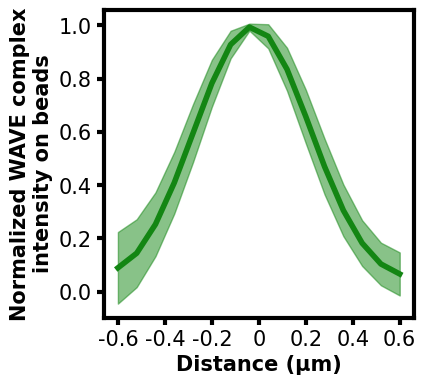

In [10]:
#Generate linescane plots
_,ax = plt.subplots(figsize=(4,4))
plt.plot(linescan_norm['Distance'],linescan_norm['mean'],color = '#138613',lw = 4,label = 'WAVE Complex')
plt.xlabel('Distance (µm)',size = 15,fontweight = 'bold')
plt.ylabel('Normalized WAVE complex\nintensity on beads',size = 15,fontweight = 'bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(ticks = [0,0.2,0.4,0.6,0.8,1.0,1.2],labels= [ -0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize = 15)
plt.yticks(fontsize = 15)
plt.fill_between(linescan_norm['Distance'],linescan_norm['mean']-linescan_norm['std'],linescan_norm['mean']+linescan_norm['std'],alpha = 0.5,color = '#138613')

plt.savefig(PATH + 'FigureS3H_WAVE_intens_on_beads.png',bbox_inches = 'tight',dpi = 300)